# Notebook for Edge et al. (2022) JGR:JAMES submission

## Case Study 2: Erosion model 1

Notes:
- This version of the notebook was not run in an optimized Python environment (g++, chain parallelization). 


In [1]:
import os
import glob
import numpy as np
import xarray as xr
import pandas as pd
import arviz as az
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from edge_funcs import *

%matplotlib inline

sns.set()
sns.set_style("white")
sns.set_style("ticks")

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Create the synthetic forcing data

In [2]:
del_z = 1.0
del_t = 300.0
h_tot = 16.0

bbl_h_start = 15
km_bg = 10**-4

fg, mg, tg = generate_grid(h_tot, del_z, 12*60*60, del_t) 
print('Grid size = ', str(len(mg)), ' x ', str(len(tg)))

Grid size =  16  x  145


In [3]:
# Specify a u* time series for diffusivity profile
f_wave = 0.17*np.sin(np.linspace(-np.pi/2,3.5*np.pi,len(tg))) + 0.20
u_bed = np.sqrt((f_wave)**2 * 0.00185)
t_bed = 1035*u_bed**2

# Calculate diffusivity profile
Ks_all = calc_Ks(u_bed, fg, np.repeat(bbl_h_start, len(tg)), km_bg)

## Create the synthetic SSC data

#### Pick some realistic parameters from literature

In [4]:
w_s = 1.0 # [mm/s]
t_c = 7.0 # [x10-2]
e_0 = 3.0 # [x10-4]
m_c = None
b_c = 1.1 # close to one makes the model difficult to sample

theta_syn = [w_s, e_0, t_c, m_c, b_c, 0]

In [5]:
# Run the model once to get initial profile
model_spec = [tg, mg, fg, np.zeros_like(mg), Ks_all, h_tot, t_bed]

syn_init = obj(theta_syn, 'E1', model_spec, True)
cn_rn = syn_init[-1,:]

# Run the model again to get the final synthetic data
model_spec = [tg, mg, fg, cn_rn, Ks_all, h_tot, t_bed]
syn_final = obj(theta_syn, 'E1', model_spec, True)


## Add noise to the synthetic SSC


In [6]:
obs_htx = ((mg >= 0.5) & (mg <= 1.4)) | ((mg >= 8.5) & (mg <= 9.4))

obs_mod = np.copy(syn_final)

noise_sd = 2/1000
noise_meas = np.random.normal(0, noise_sd, np.shape(obs_mod))
obs_meas = obs_mod + noise_meas

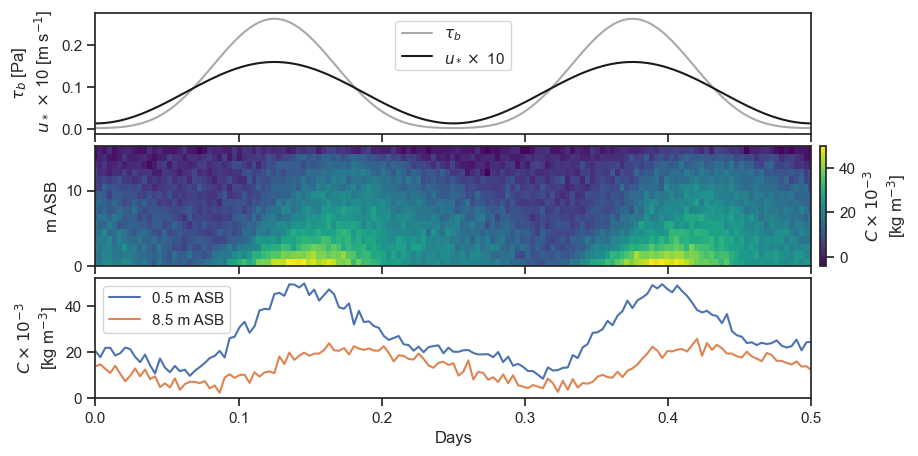

In [7]:
fig, ax = plt.subplots(3, 1, figsize=(11,5))
plt.subplots_adjust(hspace=0.1)

ax[0].plot(tg/60/60/24, t_bed, label='$\\tau_b$', c='darkgrey')
ax[0].plot(tg/60/60/24, 10*u_bed, label=r'$u_* \times$ 10', c='k')

ax[0].set_ylabel('$\\tau_b$ [Pa]\n $u_*$ $\\times$ 10 [m s$^{-1}$]')
ax[0].legend()

pc=ax[1].pcolor(tg/60/60/24, mg, 1000*obs_meas.T, cmap=cm.viridis)
cb2 = fig.colorbar(pc, ax=ax[1], pad=0.01)
mpl.colorbar.ColorbarBase.set_label(cb2, '$C \\times 10^{-3}$\n[kg m$^{-3}$]')

ax[1].set_ylabel('m ASB')
ax[2].plot(tg/60/60/24, obs_meas.T[obs_htx][0]*1000, label='0.5 m ASB')
ax[2].plot(tg/60/60/24, obs_meas.T[obs_htx][1]*1000, label='8.5 m ASB')
ax[2].legend()

ax[2].set_ylabel('$C \\times 10^{-3}$\n[kg m$^{-3}$]')
ax[2].set_xlabel('Days')

ax_zero = ax[1].get_position().bounds
for x in ax:
    x.set_xlim(0, tg[-1]/60/60/24)
    if x != ax[-1]:
        x.set_xlabel('')
        x.set_xticklabels('')

    if x != ax[1]:
        ax_one = x.get_position().bounds
        x.set_position([ax_zero[0], ax_one[1], ax_zero[2], ax_one[3]])

# Run the inference

See edge_funcs.py for numerical model code, log-likelihood function, and related functions

In [8]:
model_spec = [tg, mg, fg, syn_final[-1,:], Ks_all, h_tot, t_bed]

In [9]:
# create operation
logl = LogLike(my_loglike, obs_meas, 'E1', model_spec, obs_htx, True)

# create model and set priors
with pm.Model() as model:
    w_s_pdf = pm.Lognormal('w_s', mu=0.5, sigma=0.7)
    e_0_pdf = pm.HalfNormal('e_0', sd=20)
    t_c_pdf = pm.HalfNormal('t_c', sd=3)
    m_c_pdf = 0.0
    b_c_pdf = pm.Lognormal('b_c', mu=0.25, sigma=0.5)
    sig_pdf = pm.HalfNormal('sig_mod', 3.0)

    # Convert parameters to a tensor vector
    theta = tt.as_tensor_variable([w_s_pdf, e_0_pdf, t_c_pdf, m_c_pdf, b_c_pdf, sig_pdf])
    
    # Specify custom log-likelihood (standard Guassian that takes numerical model output - see edge_funcs.py)
    likelihood = pm.DensityDist("likelihood", lambda v: logl(v), observed={"v": theta})
    
#     # Save log-likelihood value (extra step - increases run time)
#     llk = pm.Deterministic('logp', model.logpt)

In [10]:
# with model:
#     trace_norm = pm.sample(20000, step=pm.DEMetropolis(), chains=12, tune=10000,\
#                            pickle_backend='dill', cores=1, compute_convergence_checks=False)

In [11]:
# with model:
#     id_all = az.from_pymc3(trace_norm, density_dist_obs=False, log_likelihood=False)
# i_xr = az.convert_to_dataset(id_all)
# i_xr_result = i_xr.isel(draw=np.arange(10000,30000)))
# i_xr_result.to_netcdf(path='CS2_E1', mode='w')
# print('Trace saved')

i_xr_result = xr.open_dataset('CS2_E1', engine='netcdf4', mode='r')
print('Trace loaded') 

Trace loaded


# Plot the trace

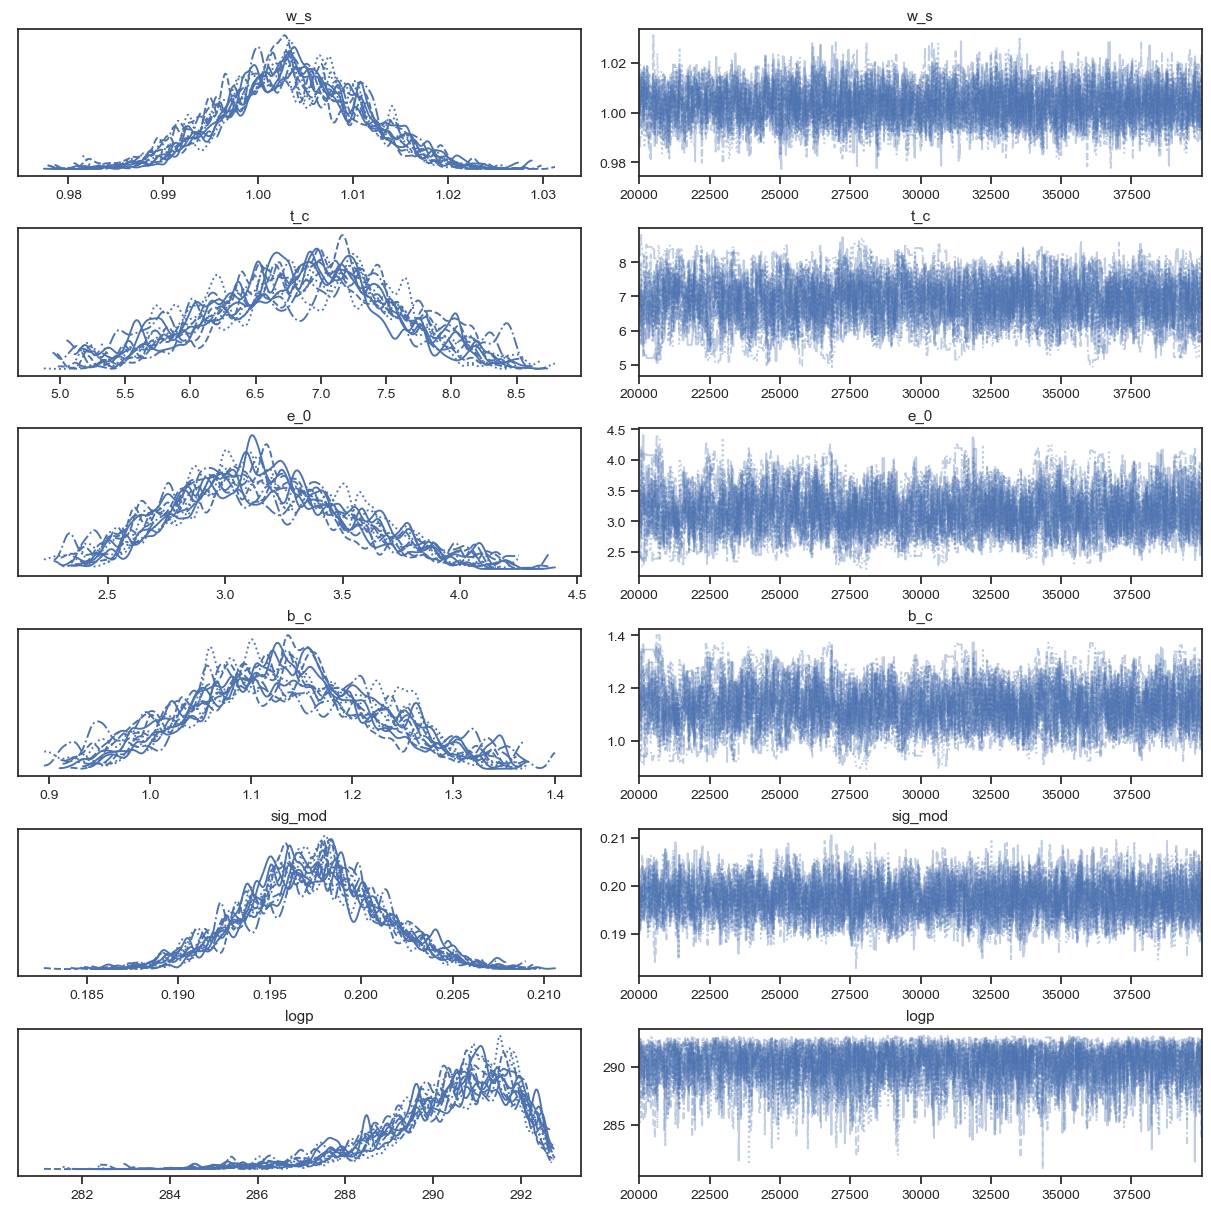

In [12]:
_=az.plot_trace(i_xr_result)

In [13]:
az.summary(i_xr_result)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w_s,1.004,0.007,0.991,1.017,0.000,0.000,2754.0,3496.0,1.00
t_c,6.867,0.693,5.605,8.185,0.021,0.015,1009.0,912.0,1.01
e_0,3.164,0.378,2.490,3.885,0.012,0.008,985.0,902.0,1.02
b_c,1.133,0.091,0.965,1.302,0.003,0.002,955.0,775.0,1.02
sig_mod,0.197,0.004,0.190,0.204,0.000,0.000,2751.0,3996.0,1.00
logp,290.392,1.477,287.710,292.616,0.033,0.023,2046.0,3579.0,1.01


In [14]:
df = i_xr_result.to_dataframe()
df.reset_index(drop=True, inplace=True)

# Force correct order
dcols = ['w_s', 'e_0', 't_c', 'b_c', 'sig_mod']
df = df[dcols]

In [15]:
w_s_prior = w_s_pdf.random(size=len(df))
t_c_prior = t_c_pdf.random(size=len(df))
e_0_prior = e_0_pdf.random(size=len(df))
b_c_prior = b_c_pdf.random(size=len(df))
sig_prior = sig_pdf.random(size=len(df))

df_prior = pd.DataFrame({'w_s':w_s_prior, 'e_0':e_0_prior, 't_c':t_c_prior, 'b_c':b_c_prior, 'sig_mod':sig_prior})

### Plot posteriors (with priors)

(1.8, 2.25)

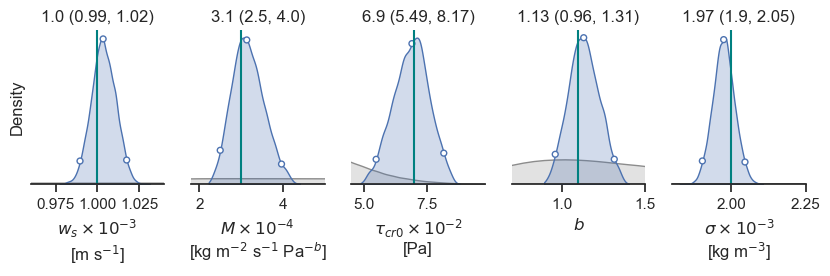

In [16]:
fig, ax = plt.subplots(1, 5, figsize=(10,2), constrained_layout=False)

labs = ['$w_s \\times 10^{-3}$\n[m s$^{-1}$]', '$M \\times 10^{-4}$\n[kg m$^{-2}$ s$^{-1}$ Pa$^{-b}$]',\
        '$\\tau_{cr0} \\times 10^{-2}$\n[Pa]', r'$b$', '$\\sigma \\times 10^{-3}$\n[kg m$^{-3}$]']

plt_scaling = [1,1,1,1,10]

for (x, dpri, dpos, lbs, ps, mm) in zip(ax, df_prior, df, labs, plt_scaling,\
                                        np.array([w_s, e_0, t_c, b_c, 1000*noise_sd])):
    df_p = df_prior[dpri]*ps
    df_s = df[dpos]*ps
    sns.kdeplot(df_p, ax=x, fill=True,\
                color=sns.color_palette("deep", 10)[7], cut=0)
    sns.kdeplot(df_s, ax=x, fill=True, bw_adjust=2.0,\
                color=sns.color_palette("deep", 10)[0], cut=0)

    ldt = sns.kdeplot(df_s, alpha=0, ax=x, bw_adjust=2.0,\
                        cut=0).get_lines()[0].get_data()
    x.axvline(mm, c='teal', linewidth=1.5)
    
    ax_med = np.median(df_s)
    ax_025 = np.percentile(df_s, 2.5)
    ax_975 = np.percentile(df_s, 97.5)
    
    ax_med_ix = np.argmin(np.abs(ax_med - ldt[0]))
    ax_025_ix = np.argmin(np.abs(ax_025 - ldt[0]))
    ax_975_ix = np.argmin(np.abs(ax_975 - ldt[0]))
    ax_plt = [ax_025_ix, ax_med_ix, ax_975_ix]
    
    sns.scatterplot(x=ldt[0][ax_plt], y=ldt[1][ax_plt], ax=x,\
                    facecolor='w',\
                    edgecolor=sns.color_palette("deep", 10)[0],\
                    size=8, linewidth=1, legend=False)
    if x==ax[1]:
        x.set_title(str(np.round(ax_med, 1)) + ' (' + str(np.round(ax_025, 1)) + ', ' +\
                    str(np.round(ax_975, 1)) + ')')
    else:
        x.set_title(str(np.round(ax_med, 2)) + ' (' + str(np.round(ax_025, 2)) + ', ' +\
                    str(np.round(ax_975, 2)) + ')')
        
    x.set_xlabel(lbs)

    x.spines['right'].set_visible(False)
    x.spines['left'].set_visible(False)
    x.spines['top'].set_visible(False)

    x.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    if x != ax[0]:
        x.set_ylabel('')
    if x != ax[0]:
        x.set_ylabel('')
ax[0].set_xlim(0.96,1.04)
ax[2].set_xlim(4.5,9.8)
ax[1].set_xlim(1.8,5)
ax[3].set_xlim(0.7,1.5)
ax[4].set_xlim(1.8,2.25)

# Sample the model posterior

In [17]:
n_samp = 1000 # 10,000 for paper
trace_len = len(df)
rand_init = np.random.randint(0, trace_len, (n_samp))
samp_res = np.full((n_samp, len(tg), len(mg)), np.nan)
samp_noi = np.full((n_samp, len(tg), len(mg)), np.nan)

for ix, ri in enumerate(rand_init):
    theta_pred = [df['w_s'][ri], df['e_0'][ri], df['t_c'][ri], 0.0, df['b_c'][ri]]
    samp_res[ix,:,:] = obj(theta_pred, 'E1', model_spec, True)
    
    # Scale sigma same as log-likelihood (/100)
    samp_noi[ix,:,:] = np.random.normal(loc=0, \
                                      scale=df['sig_mod'][ri]/100,\
                                      size=(len(tg),len(mg)))

In [18]:
noi_CI16 = np.percentile((samp_res + samp_noi)[:,:,0], 25, axis=0)
noi_CI84 = np.percentile((samp_res + samp_noi)[:,:,0], 75, axis=0)

noi_CI05 = np.percentile((samp_res + samp_noi)[:,:,0], 10, axis=0)
noi_CI95 = np.percentile((samp_res + samp_noi)[:,:,0], 90, axis=0)

noi_CI01 = np.percentile((samp_res + samp_noi)[:,:,0], 2.5, axis=0)
noi_CI99 = np.percentile((samp_res + samp_noi)[:,:,0], 97.5, axis=0)

hih_CI16 = np.percentile((samp_res + samp_noi)[:,:,8], 25, axis=0)
hih_CI84 = np.percentile((samp_res + samp_noi)[:,:,8], 75, axis=0)

hih_CI05 = np.percentile((samp_res + samp_noi)[:,:,8], 10, axis=0)
hih_CI95 = np.percentile((samp_res + samp_noi)[:,:,8], 90, axis=0)

hih_CI01 = np.percentile((samp_res + samp_noi)[:,:,8], 2.5, axis=0)
hih_CI99 = np.percentile((samp_res + samp_noi)[:,:,8], 97.5, axis=0)

Text(0, 0.5, '$b$')

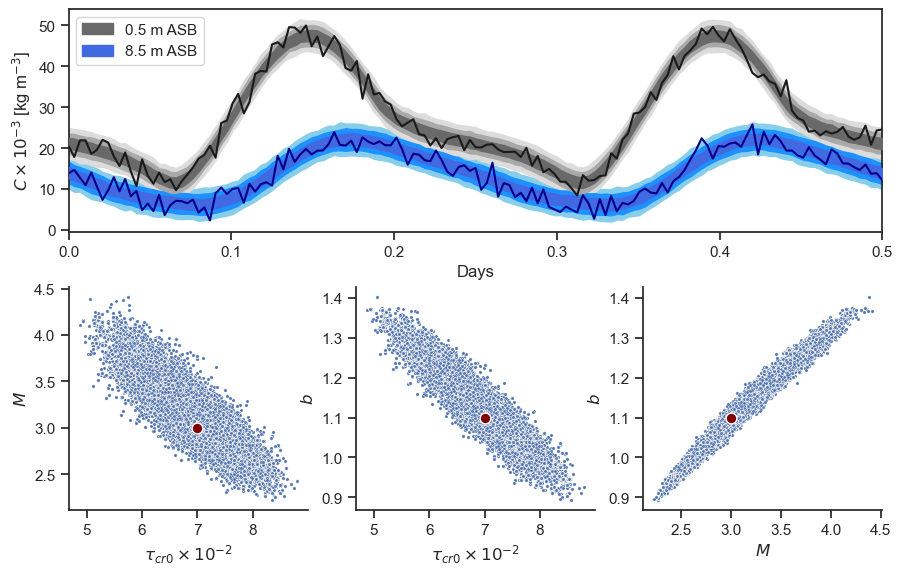

In [19]:
fig = plt.figure(figsize=(10.5,6.5), constrained_layout=False)
gs1 = GridSpec(2, 3, figure=fig, hspace=0.25)
ax = np.empty((4,), dtype='object')
ax[0] = fig.add_subplot(gs1[0,:])
ax[1] = fig.add_subplot(gs1[1,0])
ax[2] = fig.add_subplot(gs1[1,1])
ax[3] = fig.add_subplot(gs1[1,2])

lowplt = ax[0].fill_between(tg/60/60/24, hih_CI16*1000,\
                 y2=hih_CI84*1000, color='royalblue', label='8.5 m ASB', zorder=3)
ax[0].fill_between(tg/60/60/24, hih_CI05*1000,\
                 y2=hih_CI95*1000, color='dodgerblue', zorder=2)
ax[0].fill_between(tg/60/60/24, hih_CI01*1000,\
                 y2=hih_CI99*1000, color='skyblue', zorder=1)
ax[0].plot(tg/60/60/24, 1000*obs_meas[:,8], zorder=4, c='darkblue')

hihplt = ax[0].fill_between(tg/60/60/24, noi_CI16*1000,\
                 y2=noi_CI84*1000, color='dimgrey', label='0.5 m ASB', zorder=3)
ax[0].fill_between(tg/60/60/24, noi_CI05*1000,\
                 y2=noi_CI95*1000, color='darkgrey', zorder=2)
ax[0].fill_between(tg/60/60/24, noi_CI01*1000,\
                 y2=noi_CI99*1000, color='gainsboro', zorder=1)
ax[0].plot(tg/60/60/24, 1000*obs_meas[:,0], c='k', zorder=4)

ax[0].set_ylabel(r'$C \times 10^{-3}$ [kg m$^{-3}$]')
ax[0].set_xlabel('Days')
ax[0].legend(handles=[hihplt, lowplt])
ax[0].set_xlim((tg/60/60/24)[0], (tg/60/60/24)[-1])

#####
sns.scatterplot(x=df['t_c'], y=df['e_0'], ax=ax[1], s=5)
sns.scatterplot(x=df['t_c'], y=df['b_c'], ax=ax[2], s=5)
sns.scatterplot(x=df['e_0'], y=df['b_c'], ax=ax[3], s=5)

ax[1].scatter(t_c, e_0, s=60, color='maroon', edgecolors='w')
ax[2].scatter(t_c, b_c, s=60, color='maroon', edgecolors='w')
ax[3].scatter(e_0, b_c, s=60, color='maroon', edgecolors='w')

# Very slow
# sns.kdeplot(x=df['t_c'], y=df['e_0'], ax=ax[1], levels=[0.05, 0.2 ,0.5], color='k', bw_adjust=1.5)
# sns.kdeplot(x=df['t_c'], y=df['b_c'], ax=ax[2], levels=[0.05, 0.2 ,0.5], color='k', bw_adjust=1.5)
# sns.kdeplot(x=df['e_0'], y=df['b_c'], ax=ax[3], levels=[0.05, 0.2 ,0.5], color='k', bw_adjust=1.5)

for x in ax[1:]:
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    
ax[1].set_xlabel(r'$\tau_{cr0} \times 10^{-2}$')
ax[1].set_ylabel('$M$')

ax[2].set_ylabel('$b$')
ax[2].set_xlabel(r'$\tau_{cr0} \times 10^{-2}$')

ax[3].set_xlabel('$M$')
ax[3].set_ylabel('$b$')


In [20]:
!jupyter nbconvert --to html CaseStudy2_E1_DE-MC.ipynb

[NbConvertApp] Converting notebook CaseStudy2_E1_DE-MC.ipynb to html
[NbConvertApp] Writing 2064790 bytes to CaseStudy2_E1_DE-MC.html
